In [1]:
# importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, tqdm, re, time, itertools, sys
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading all data files into memory
start = time.time()

data_train = pd.read_csv('C:/Users/mahfo/Downloads/archive (4)/mitbih_train.csv', header=None)
data_test = pd.read_csv('C:/Users/mahfo/Downloads/archive (4)/mitbih_test.csv', header=None)
abnormal = pd.read_csv('C:/Users/mahfo/Downloads/archive (4)/ptbdb_abnormal.csv', header=None)
normal = pd.read_csv('C:/Users/mahfo/Downloads/archive (4)/ptbdb_normal.csv', header=None)

end = time.time()
print('Time taken: %.3f seconds' % (end-start))

print('Data loaded........')

Time taken: 5.898 seconds
Data loaded........


In [5]:
normal = normal.drop([187], axis=1)
abnormal = abnormal.drop([187], axis=1)

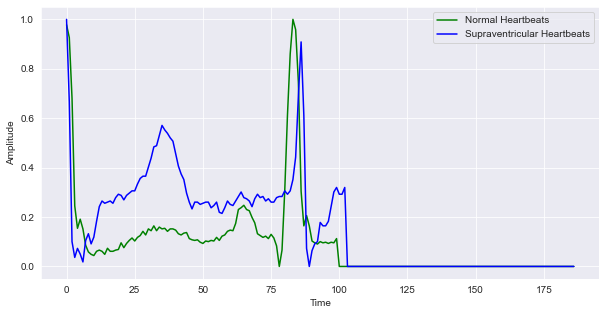

In [6]:
# making the class labels for our dataset
data_1 = data_train[data_train[187] == 1]
data_2 = data_train[data_train[187] == 2]
data_3 = data_train[data_train[187] == 3]
data_4 = data_train[data_train[187] == 4]

sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[0, 0:187], color='green', label='Normal Heartbeats')
plt.plot(data_1.iloc[0, 0:187], color='blue', label='Supraventricular Heartbeats')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

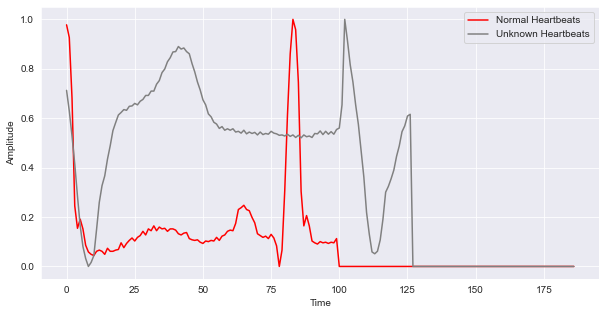

In [7]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[0, 0:187], color='red', label='Normal Heartbeats')
plt.plot(data_4.iloc[0, 0:187], color='grey', label='Unknown Heartbeats')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

In [8]:
y_abnormal = np.ones(abnormal.shape[0])
y_abnormal = pd.DataFrame(y_abnormal)

y_normal = np.zeros(normal.shape[0])
y_normal = pd.DataFrame(y_normal)

# merging the original dataframe
X = pd.concat([abnormal, normal], sort=True)
y = pd.concat([y_abnormal, y_normal], sort=True)

In [9]:
print(X.shape)
print(y.shape)

(14552, 187)
(14552, 1)


In [10]:
# checking if there are some null values in data
normal.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [11]:
# checking if there are some null values in abnormal patient data
abnormal.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [12]:
from sklearn.utils import resample
data_1_resample = resample(data_1, n_samples=20000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, 
                           random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=20000, 
                           random_state=123, replace=True)
data_0 = data_train[data_train[187] == 0].sample(n=20000, random_state=123)

In [13]:
train_dataset = pd.concat([data_0, data_1_resample, data_2_resample, data_3_resample, 
                          data_4_resample])

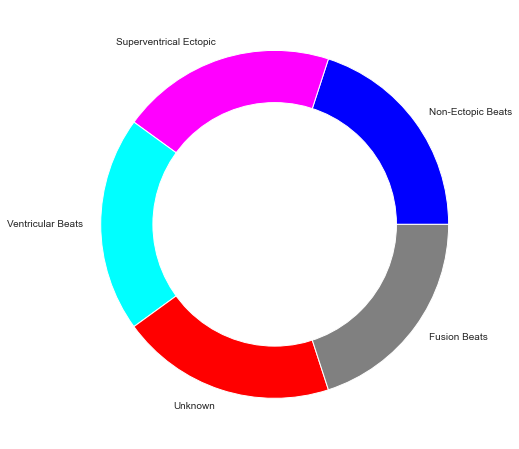

In [14]:
# viewing the distribution of beats in our dataset 
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(train_dataset[187].value_counts(), labels=['Non-Ectopic Beats', 'Superventrical Ectopic', 'Ventricular Beats',
                                                'Unknown', 'Fusion Beats'], colors=['blue', 'magenta', 'cyan', 
                                                                                   'red', 'grey'])
p = plt.gcf()
p.gca().add_artist(circle)

In [15]:
target_train = train_dataset[187]
target_test = data_test[187]
target_train.unique()

array([0., 1., 2., 3., 4.])

In [16]:
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
y_train[:4]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [17]:
# making train & test splits
X_train = train_dataset.iloc[:, :-1].values
X_test = data_test.iloc[:, :-1].values

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187)
(21892, 187)
(100000, 5)
(21892, 5)


In [19]:
c0 = data_train[data_train[187] == 0].sample(1000)
c1 = data_train[data_train[187] == 1].sample(1000)
c2 = data_train[data_train[187] == 2].sample(1000)
c3 = data_train[data_train[187] == 3]
c4 = data_train[data_train[187] == 4].sample(1000)
new_data = pd.concat([c0, c1, c2, c3, c4])
new_data[187].value_counts()
new_data.shape
new_data = np.array(new_data)
X = new_data[:, : 187]
Y = new_data[:, 187]
print(X.shape)
print(Y.shape)

(4641, 187)
(4641,)


In [21]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True)
clf = svm.fit(X,Y)
# test_data = pd.read_csv('../input/heartbeat/mitbih_test.csv', header=None)
test_data = np.array(data_train)
X_test = test_data[:, :187]
Y_test = test_data[:, 187]
#sc = StandardScaler()
#sc.fit(X_test)
#X_test_std = sc.transform(X_test)
clf.score(X_test, Y_test)

0.8491686460807601